In [14]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Kraken API endpoint
url = "https://api.kraken.com/0/public/OHLC"

# Parameters
pair = "XXBTZUSD"  # BTC/USD pair
#pair = "XETHZUSD"  # ETH/USD pair

interval = 240        # 1440-minute intervals (1day)

# Parameters
short_term_window = 7
long_term_window = 25

In [16]:

# Calculate the Unix timestamp for the start of the week
today = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)
since = int(time.mktime(today.timetuple()) - timedelta(days=long_term_window).total_seconds())


# Make the API request
response = requests.get(url, params={"pair": pair, "interval": interval, "since": since})
data = response.json()

# Extract and print the hourly prices
if data["error"]:
    print("Error:", data["error"])
else:
    ohlc_data = data["result"][pair] #ohlc stands for open, high, low, close
    for entry in ohlc_data:
        timestamp = datetime.utcfromtimestamp(entry[0])
        open_price = entry[1]
        high_price = entry[2]
        low_price = entry[3]
        close_price = entry[4]
        print(f"Time: {timestamp}, Open: {open_price}, High: {high_price}, Low: {low_price}, Close: {close_price}")


Time: 2025-02-18 04:00:00, Open: 96186.1, High: 96234.6, Low: 95301.0, Close: 95478.1
Time: 2025-02-18 08:00:00, Open: 95478.1, High: 95833.0, Low: 95124.1, Close: 95629.1
Time: 2025-02-18 12:00:00, Open: 95629.1, High: 96650.9, Low: 95176.9, Close: 95504.1
Time: 2025-02-18 16:00:00, Open: 95504.1, High: 95600.0, Low: 93388.7, Close: 94066.6
Time: 2025-02-18 20:00:00, Open: 94066.7, High: 95600.0, Low: 93733.1, Close: 95600.0
Time: 2025-02-19 00:00:00, Open: 95600.0, High: 95831.3, Low: 94996.8, Close: 95639.2
Time: 2025-02-19 04:00:00, Open: 95639.3, High: 95781.0, Low: 95075.4, Close: 95670.6
Time: 2025-02-19 08:00:00, Open: 95670.6, High: 96367.5, Low: 95598.9, Close: 96354.0
Time: 2025-02-19 12:00:00, Open: 96354.0, High: 96682.9, Low: 95578.6, Close: 95911.0
Time: 2025-02-19 16:00:00, Open: 95911.1, High: 96465.8, Low: 95442.1, Close: 96120.8
Time: 2025-02-19 20:00:00, Open: 96120.9, High: 96875.0, Low: 96050.0, Close: 96625.7
Time: 2025-02-20 00:00:00, Open: 96625.7, High: 97291.

In [17]:

needed = []
for entry in ohlc_data:
    timestamp = datetime.utcfromtimestamp(entry[0])
    open_price = entry[1]
    high_price = entry[2]
    low_price = entry[3]
    close_price = entry[4]
    needed.append([timestamp, open_price, high_price, low_price, close_price])


def CreateDF(data):
    df = pd.DataFrame(data, columns=["Time", "Open", "High", "Low", "Close"])
    # Convert the timestamp to datetime
    df["Time"] = pd.to_datetime(df["Time"], unit='s')
    df.set_index("Time", inplace=True)
    
    # Convert price columns to floats
    df["Open"] = df["Open"].astype(float)
    df["High"] = df["High"].astype(float)
    df["Low"] = df["Low"].astype(float)
    df["Close"] = df["Close"].astype(float)
    
    return df



dateframe = CreateDF(needed)
print(dateframe)

                        Open     High      Low    Close
Time                                                   
2025-02-18 04:00:00  96186.1  96234.6  95301.0  95478.1
2025-02-18 08:00:00  95478.1  95833.0  95124.1  95629.1
2025-02-18 12:00:00  95629.1  96650.9  95176.9  95504.1
2025-02-18 16:00:00  95504.1  95600.0  93388.7  94066.6
2025-02-18 20:00:00  94066.7  95600.0  93733.1  95600.0
...                      ...      ...      ...      ...
2025-03-14 20:00:00  84591.1  84591.1  83750.0  83997.6
2025-03-15 00:00:00  83997.7  84659.4  83997.6  84500.7
2025-03-15 04:00:00  84500.8  84559.4  83802.9  83838.9
2025-03-15 08:00:00  83839.0  84121.0  83666.9  84121.0
2025-03-15 12:00:00  84121.0  84473.4  84023.0  84311.0

[153 rows x 4 columns]


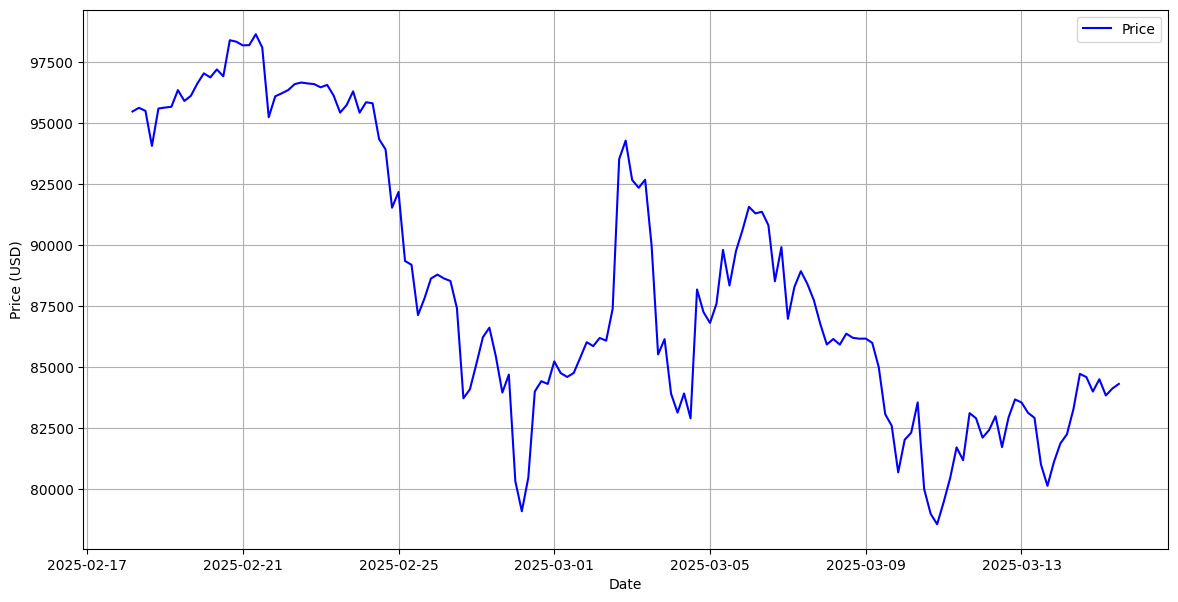

In [18]:
def graph_data(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='blue')    
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

graph_data(dateframe)

In [19]:
def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

short_momentum = calculate_ema(dateframe, short_term_window)
long_momentum = calculate_ema(dateframe, long_term_window)

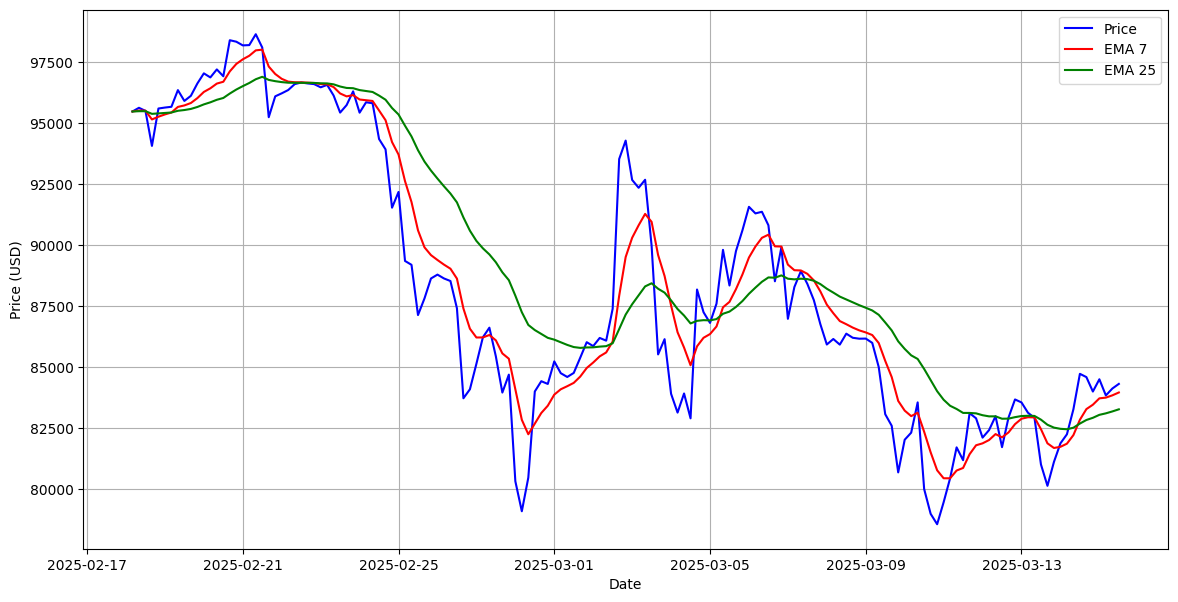

In [20]:
def plot_ema(df, short_momentum, long_momentum):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'EMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'EMA {long_term_window}', color='green')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

plot_ema(dateframe, short_momentum, long_momentum)

In [21]:
initial_balance = 100  # Starting balance in USD
btc_balance = 0
position = False
buy_price = 0
trade_log = []

def simulate_trading(df, short_momentum, long_momentum):
    global initial_balance, btc_balance, position, buy_price

    for i in range(1, len(df)):
        # Check for BUY signal
        if short_momentum.iloc[i] > long_momentum.iloc[i] and short_momentum.iloc[i - 1] <= long_momentum.iloc[i - 1]:
            if not position:
                # BUY action
                buy_price = df['Close'].iloc[i]
                btc_balance = initial_balance / buy_price
                initial_balance = 0
                position = True
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'BUY',
                    'Price': buy_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"BUY at {buy_price:.2f} on {df.index[i].date()}")

        # Check for SELL signal
        elif short_momentum.iloc[i] < long_momentum.iloc[i] and short_momentum.iloc[i - 1] >= long_momentum.iloc[i - 1]:
            if position:
                # SELL action
                sell_price = df['Close'].iloc[i]
                initial_balance = btc_balance * sell_price
                btc_balance = 0
                position = False
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'SELL',
                    'Price': sell_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"SELL at {sell_price:.2f} on {df.index[i].date()}")

    # Final value if holding BTC
    if position:
        final_price = df['Close'].iloc[-1]
        initial_balance = btc_balance * final_price
        trade_log.append({
            'Date': df.index[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'BTC Balance': 0,
            'USD Balance': initial_balance
        })
        print(f"FINAL SELL at {final_price:.2f} on {df.index[-1].date()}")

simulate_trading(dateframe, short_momentum, long_momentum)

BUY at 95629.10 on 2025-02-18
SELL at 94066.60 on 2025-02-18
BUY at 96354.00 on 2025-02-19
SELL at 96600.10 on 2025-02-22
BUY at 87392.00 on 2025-03-02
SELL at 83905.10 on 2025-03-04
BUY at 89805.40 on 2025-03-05
SELL at 86762.30 on 2025-03-07
BUY at 84724.20 on 2025-03-14
FINAL SELL at 84311.00 on 2025-03-15


In [22]:
trade_log_df = pd.DataFrame(trade_log)
print(trade_log_df)

                 Date      Action    Price  BTC Balance  USD Balance
0 2025-02-18 08:00:00         BUY  95629.1     0.001046     0.000000
1 2025-02-18 16:00:00        SELL  94066.6     0.000000    98.366083
2 2025-02-19 08:00:00         BUY  96354.0     0.001021     0.000000
3 2025-02-22 20:00:00        SELL  96600.1     0.000000    98.617322
4 2025-03-02 12:00:00         BUY  87392.0     0.001128     0.000000
5 2025-03-04 00:00:00        SELL  83905.1     0.000000    94.682537
6 2025-03-05 08:00:00         BUY  89805.4     0.001054     0.000000
7 2025-03-07 20:00:00        SELL  86762.3     0.000000    91.474173
8 2025-03-14 12:00:00         BUY  84724.2     0.001080     0.000000
9 2025-03-15 12:00:00  FINAL SELL  84311.0     0.000000    91.028053


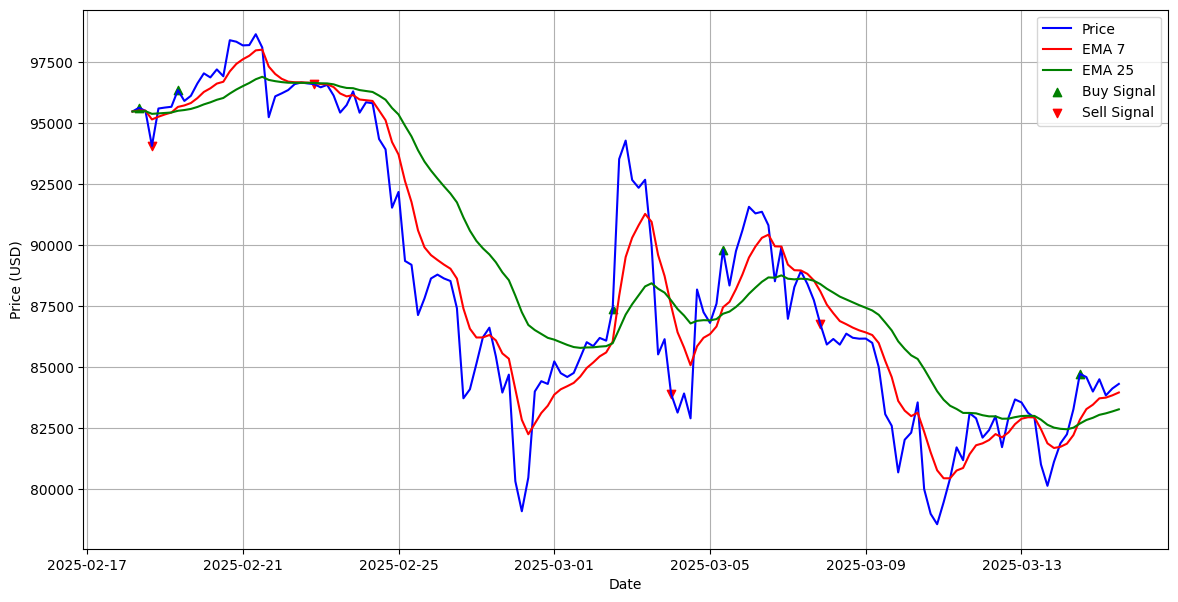

In [23]:
def plot_trades(df, short_momentum, long_momentum, trades):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'EMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'EMA {long_term_window}', color='green')

    # Plot Buy signals
    buys = trades[trades['Action'] == 'BUY']
    plt.scatter(buys['Date'], buys['Price'], marker='^', color='green', label='Buy Signal', alpha=1)

    # Plot Sell signals
    sells = trades[trades['Action'] == 'SELL']
    plt.scatter(sells['Date'], sells['Price'], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

# Plot trades
plot_trades(dateframe, short_momentum, long_momentum, trade_log_df)

In [24]:
initial_value = 100
final_value = initial_balance
profit = final_value - initial_value
roi = (profit / initial_value) * 100

print(f"Initial Balance: ${initial_value:.2f}")
print(f"Final Balance: ${final_value:.2f}")
print(f"Profit: ${profit:.2f}")
print(f"ROI: {roi:.2f}%")

Initial Balance: $100.00
Final Balance: $91.03
Profit: $-8.97
ROI: -8.97%
